In [2]:
import numpy as np

np.arange(5)

array([0, 1, 2, 3, 4])

In [24]:
# encode type

n_types = 5
t = 1
board = np.array([[-1, -1, -1], [-1, 1, -1], [-1, 1, 1]])

print("board")
print(board)
print("type")
print(t)

enc_types = np.zeros(n_types, dtype=bool)
enc_types[t] = 1

enc_board = (board==1).flatten()
print("enc_board")
print(enc_board)

print("enc_types")
print(enc_types)

occ = np.hstack((enc_board, enc_types))
print("occ")
print(occ)

pow = 1<<np.arange(occ.size)
print("pow")
print(pow)

code = pow@occ
print("code")
print(code)


def encode_state(n_tiles, board, tile_type):
    enc_types = np.zeros(n_tiles, dtype=bool)
    enc_types[tile_type] = 1
    enc_board = (board==1).flatten()

    occ = np.hstack((enc_board, enc_types))
    pow = 1 << np.arange(occ.size)
    code = pow@occ

    return code


print("func output")
encode_state(n_types, board, t)



board
[[-1 -1 -1]
 [-1  1 -1]
 [-1  1  1]]
type
1
enc_board
[False False False False  True False False  True  True]
enc_types
[False  True False False False]
occ
[False False False False  True False False  True  True False  True False
 False False]
pow
[   1    2    4    8   16   32   64  128  256  512 1024 2048 4096 8192]
code
1424
func output


1424

In [31]:
n_pos = 10
n_ori = 4

tile_positions = np.arange(n_pos)
tile_orientations = np.arange(n_ori)

tile_positions = np.repeat(np.arange(n_pos, dtype=int), n_ori)
tile_orientations = np.tile(np.arange(n_ori, dtype=int), n_pos)
actions = np.vstack((tile_positions, tile_orientations)).T
actions

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [5, 0],
       [5, 1],
       [5, 2],
       [5, 3],
       [6, 0],
       [6, 1],
       [6, 2],
       [6, 3],
       [7, 0],
       [7, 1],
       [7, 2],
       [7, 3],
       [8, 0],
       [8, 1],
       [8, 2],
       [8, 3],
       [9, 0],
       [9, 1],
       [9, 2],
       [9, 3]])

In [18]:
import gmpy2

int(gmpy2.pack([1 for _ in range(65)], 1))

36893488147419103231

In [118]:
import numpy as np
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SmallStateAutoEncoder(nn.Module):
    def __init__(self, d_L, d_H) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 2, padding=1),
            nn.ReLU(),
            nn.Flatten(1),   # dim 
            nn.Linear(400, d_H),
            nn.ReLU(),
            nn.Linear(d_H, d_L),
            nn.ReLU(),
        )        

        self.decoder = nn.Sequential(
            nn.Linear(d_L, d_H),
            nn.ReLU(),
            nn.Linear(d_H, 256),
            nn.ReLU(),
            nn.Unflatten(1, (16, 4, 4)),
            nn.ConvTranspose2d(16, 1, 1, stride=1, padding=0),
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.tanh(x)
        

In [322]:
import numpy as np

data = np.random.choice([-1, 1], size=(128, 128, 1, 4, 4))
data = torch.Tensor(data)


In [324]:
ae_small = SmallStateAutoEncoder(32, 64).to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae_small.parameters(), lr=3E-4)
load_small_encoder = False
save_small_encoder = True

losses = []
run_loss = 0
n_epochs = 200

if load_small_encoder:
    ae_small.load_state_dict(torch.load('./src/models/ae_small.pt'))

ae_small.train()
for epoch in range(n_epochs):

    run_loss = 0
    for x in data:
        optim.zero_grad()
        x = x.to(device)

        y = ae_small(x)

        loss = loss_fn(y, x)
        run_loss += loss.item()

        loss.backward()
        optim.step()

    train_loss = run_loss / len(data)
    losses.append(train_loss)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}/{n_epochs}')
        print(f'loss: {train_loss}')


if save_small_encoder:
    ae_small.eval()
    torch.save(
        ae_small.state_dict(), './src/models/ae_small.pt'
    )

epoch: 0/200
loss: 0.7509096246212721
epoch: 10/200
loss: 6.290278241749547e-05
epoch: 20/200
loss: 1.4597502861590783e-05
epoch: 30/200
loss: 5.408257528927152e-06
epoch: 40/200
loss: 2.269945861499423e-06
epoch: 50/200
loss: 1.0324067267752923e-06
epoch: 60/200
loss: 4.849360861758356e-07
epoch: 70/200
loss: 2.3432122764344143e-07
epoch: 80/200
loss: 1.151354260264803e-07
epoch: 90/200
loss: 5.7062849639910596e-08
epoch: 100/200
loss: 2.8471262167317768e-08
epoch: 110/200
loss: 1.4308779112959247e-08
epoch: 120/200
loss: 7.258067966087189e-09
epoch: 130/200
loss: 3.724352557257782e-09
epoch: 140/200
loss: 1.9416795185578373e-09
epoch: 150/200
loss: 1.033027865072339e-09
epoch: 160/200
loss: 5.63681824957904e-10
epoch: 170/200
loss: 3.1703688242387673e-10
epoch: 180/200
loss: 1.8469215729271377e-10
epoch: 190/200
loss: 1.1199724752209567e-10


[[21.066587 27.634527 19.796804 10.164197 27.597885  9.57986  13.770809
  20.1882  ]]


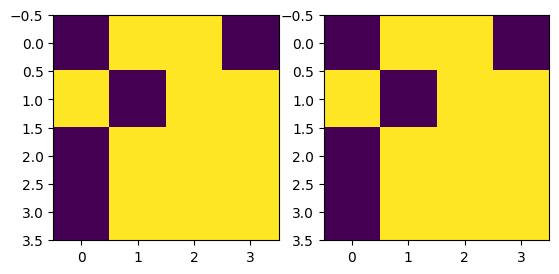

In [123]:
import matplotlib.pyplot as plt

ex_grid = np.array([[-1, 1, 1, -1], [1, -1, 1, 1], [-1, 1, 1, 1], [-1, 1, 1, 1]])
ex_grid = ex_grid.reshape(1, 1, 4, 4)
ex_grid = torch.Tensor(ex_grid).to(device)

ae_small.eval()
ex_y = torch.sgn(ae_small(ex_grid))
print(ae_small.encoder(ex_grid).detach().cpu().numpy())

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(ex_grid.detach().cpu().numpy().squeeze())
ax2.imshow(ex_y.detach().cpu().numpy().squeeze())

In [296]:
import numpy as np
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LargeStateAutoEncoder(nn.Module):
    def __init__(self, d_L, d_H) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 2, padding=1),
            nn.ReLU(),
            nn.Flatten(1),
            nn.Linear(5184, d_H),
            nn.ReLU(),
            nn.Linear(d_H, d_H),
            nn.ReLU(),
            nn.Linear(d_H, d_L),
            nn.ReLU(),
        )        

        self.decoder = nn.Sequential(
            nn.Linear(d_L, d_H),
            nn.ReLU(),
            nn.Linear(d_H, d_H),
            nn.ReLU(),
            nn.Linear(d_H, 5184),
            nn.ReLU(),
            nn.Unflatten(1, (64, 9, 9)),
            nn.ConvTranspose2d(64, 32, 1, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.tanh(x)
        

In [309]:
import numpy as np

data = np.random.choice([-1, 1], size=(128, 128, 1, 8, 8))
data = torch.Tensor(data)


In [320]:
ae_large = LargeStateAutoEncoder(32, 128).to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae_large.parameters(), lr=3E-6)
load_large_encoder = True
save_large_encoder = True

losses = []
run_loss = 0
n_epochs = 150

if load_large_encoder:
    ae_large.load_state_dict(torch.load('./src/models/ae_large.pt'))

ae_large.train()
for epoch in range(n_epochs):

    run_loss = 0
    for x in data:
        optim.zero_grad()
        x = x.to(device)

        y = ae_large(x)

        loss = loss_fn(y, x)
        run_loss += loss.item()

        loss.backward()
        optim.step()

    train_loss = run_loss / len(data)
    losses.append(train_loss)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}/{n_epochs}')
        print(f'loss: {train_loss}')


if save_large_encoder:
    ae_large.eval()
    torch.save(
        ae_large.state_dict(), './src/models/ae_large.pt'
    )

epoch: 0/150
loss: 0.0017165556284908234
epoch: 10/150
loss: 0.001385567834631729
epoch: 20/150
loss: 0.0012617767756637477
epoch: 30/150
loss: 0.0011695029252223321
epoch: 40/150
loss: 0.0010905382446253498
epoch: 50/150
loss: 0.0010294391679508408
epoch: 60/150
loss: 0.0009761655542206427
epoch: 70/150
loss: 0.0009277103441718282
epoch: 80/150
loss: 0.0008749427829570777
epoch: 90/150
loss: 0.0008345197030621421
epoch: 100/150
loss: 0.0007961094048596351
epoch: 110/150
loss: 0.0007606552172774173
epoch: 120/150
loss: 0.0007260815243625984
epoch: 130/150
loss: 0.0006907205000743488
epoch: 140/150
loss: 0.0006562731118719967


torch.Size([128, 1, 8, 8])


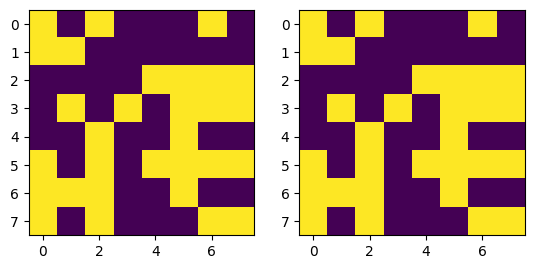

In [319]:
import matplotlib.pyplot as plt

ex_grid = data[0]
ex_grid = torch.Tensor(ex_grid).to(device)
print(ex_grid.shape)

ae_large.eval()
ex_y = torch.sgn(ae_large(ex_grid))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(ex_grid[0].detach().cpu().numpy().squeeze())
ax2.imshow(ex_y[0].detach().cpu().numpy().squeeze())